In [1]:
import torch
import torch.autograd as autograd

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

In [2]:
from FCN import FCN
from tools import *

In [3]:
%matplotlib inline

In [4]:
X, Y, T = generate_domain()
X_train, T_train, X_test, X_train_Nu, T_train_Nu = generate_BC(X, Y, T)
X_train_PDE = generate_PDE()

x = X[:,0]
y = Y[0,:]

/Users/thyagocapitanio/anaconda3/lib/python3.10/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_2a19nf9hj1/croot/pytorch_1675190251927/work/aten/src/ATen/native/TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [5]:
def partial_diff_equation(f, g):
    f_x_y = autograd.grad(f,g,torch.ones([g.shape[0], 1]), retain_graph=True, create_graph=True)[0] #first derivative
    f_xx_yy = autograd.grad(f_x_y,g,torch.ones(g.shape), create_graph=True)[0]#second derivative

    f_yy = f_xx_yy[:,[1]] # we select the 2nd element for y (the first one is x) (Remember the input X=[x,y]) 
    f_xx = f_xx_yy[:,[0]] # we select the 1st element for x (the second one is y) (Remember the input X=[x,y])

    u = f_xx + f_yy # loss equation
    u = u.float()

    return u

In [6]:
PINN = FCN(layers, X_train_PDE, X_train, T_train, X_test, partial_diff_equation)
PINN.load_state_dict(torch.load('./PINN_file.pt'))

<All keys matched successfully>

In [7]:
u_pred = PINN.forward(X_test)
u_pred.shape

torch.Size([40000, 1])

In [53]:
u_pred = np.reshape(np.transpose(u_pred), (200, 200))

<Axes: >

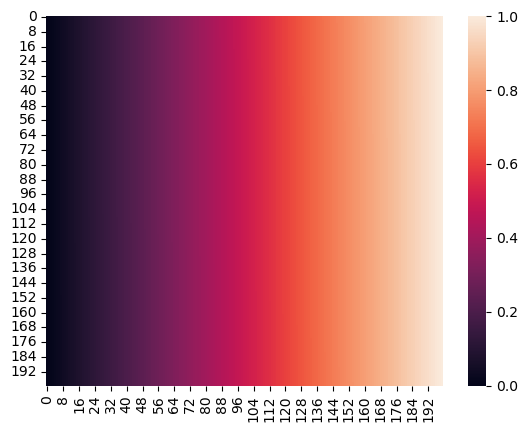

In [54]:
sns.heatmap(u_pred)

<Axes: >

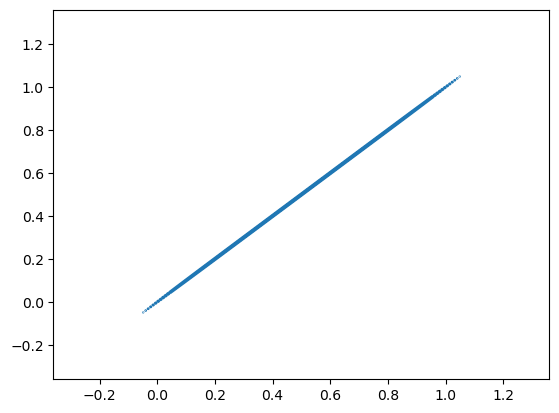

In [55]:
sns.kdeplot(u_pred, x = x, y = y)

In [ ]:
plt.figure(figsize=(10, 10))
sns.set(font_scale=1.5)

sns.heatmap(u_pred,
            cmap = 'coolwarm',
            annot = True,
            fmt = '.5g',
            vmax = 200)

plt.xlabel('Predicted',fontsize=22)
plt.ylabel('Actual',fontsize=22)
plt.show()